## Win/Loss Rating Model Prediction

Load the model and make predictions

In [1]:
import requests
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from wl_model.spcl_case import *
plt.style.use('fivethirtyeight')
%matplotlib inline

### Get a list of all CS Games

## Load Ratings Model

In [2]:
TEAM_SET = 'all_time'

teams = np.load('wl_model/saved_model/'+TEAM_SET+'/teams.npy')
maps = np.load('wl_model/saved_model/'+TEAM_SET+'/maps.npy')
periods = np.load('wl_model/saved_model/'+TEAM_SET+'/periods.npy')
filt = np.load('wl_model/saved_model/'+TEAM_SET+'/filter_teams.npy')
h_teams = pd.read_csv('wl_model/hltv_csv/teams_w_ranking.csv')
h_teams = fix_teams(h_teams.set_index('ID').loc[teams])
h_teams_filt = h_teams[h_teams.Name.isin(filt)]

rating_model = prep_pymc_time_model(len(teams), len(maps), len(periods))
trace = pm.backends.text.load('wl_model/saved_model/'+TEAM_SET+'/trace', model=rating_model)

## Sample A test set

In [4]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv').set_index('Match ID')
h_matches['Date'] = pd.to_datetime(h_matches.Date)
h_matches = h_matches[(h_matches.Date >= dt.datetime(2017,1,1)) &
         (h_matches['Team 1 ID'].isin(h_teams_filt.index)) &
         (h_matches['Team 2 ID'].isin(h_teams_filt.index))]
sample_valid_set = h_matches.sample(1000, replace=False, random_state=200)
sample_valid_set['Winner'] = sample_valid_set['Team 1 Score'] >= sample_valid_set['Team 2 Score']

FileNotFoundError: File b'hltv_csv/matchResults.csv' does not exist

In [3]:
sample_valid_set = pd.read_csv('sample_valid_set.csv')
sample_valid_set = sample_valid_set[['Date', 'Team 1 ID', 'Team 2 ID', 'Map', 'Winner']]
sample_valid_set['Date'] = pd.to_datetime(sample_valid_set.Date)
sample_valid_set['Period'] = sample_valid_set['Date'].dt.to_period('M')

# Generate Predictions

In [13]:
def sig(x):
    return 1 / (1 + np.exp(-x))

from tqdm import tqdm_notebook

valid_set = []
t_rating_time = [trace['rating_%i' % i] for i in range(len(periods))]
t_rating_time_map = [trace['rating_%i | map' % i] for i in range(len(periods))]
for i,v in tqdm_notebook(sample_valid_set.iterrows()):
    t1_ind = np.where(teams == v['Team 1 ID'])[0][0]; t2_ind = np.where(teams == v['Team 2 ID'])[0][0];
    m_ind = np.where(maps == v['Map'])[0][0];
    if v['Period'] == pd.Period(dt.datetime(2017,1,1), 'M'):
        per_ind = 0
    else:
        per_ind = np.where(periods == v['Period']-1)[0][0] #make sure to test with previous period
    
    trace_1 = t_rating_time[per_ind][:,t1_ind]; trace_2 = t_rating_time[per_ind][:,t2_ind]
    diff = trace_1-trace_2
    p_wl = 0.5*np.tanh(diff)+0.5
    #wr_uncond = p_wl.mean()
    wr_uncond = np.percentile(p_wl, 45)
    
    #alpha=0.31
    #wr_cond = np.mean(16.*np.tanh(alpha*diff) > 0)

    trace_1 = t_rating_time_map[per_ind][:,m_ind,t1_ind]; trace_2 = t_rating_time_map[per_ind][:,m_ind,t2_ind]
    diff = trace_1-trace_2
    p_wl = 0.5*np.tanh(diff)+0.5
    #wr_cond = p_wl.mean()
    wr_cond = np.percentile(p_wl, 48)
    
    valid_set.append([int(v['Winner']), wr_uncond, wr_cond])
validation = np.array(valid_set)

A Jupyter Widget

In [14]:
from sklearn.metrics import roc_curve, confusion_matrix, log_loss
def print_validation_results(validation):
    print('Log Loss U: %.5f' % log_loss(validation[:,0], validation[:,1]))
    print('Log Loss C: %.5f' % log_loss(validation[:,0], validation[:,2]))

    fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,1])
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - U')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,2])
    ax.plot(fpr, tpr, color='orangered', lw=2, label='ROC curve - C')
    ax.legend(loc="lower right")

    validation_binary = validation.copy()
    validation_binary[:,1] = (validation_binary[:,1] > 0.5).astype(int)
    validation_binary[:,2] = (validation_binary[:,2] > 0.5).astype(int)

    cm = confusion_matrix(validation_binary[:,0], validation_binary[:,1])
    print("CM Unconditional")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    cm = confusion_matrix(validation_binary[:,0], validation_binary[:,2])
    print("CM Conditional")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    bins = np.vstack([np.arange(0,1,0.1), np.arange(0.1,1.1,0.1)]).T
    binned = {'U': [], 'C': []}
    for r in bins:
        binned['U'].append(validation[(validation[:,1] >= r[0])&(validation[:,1] < r[1]),0].mean())
        binned['C'].append(validation[(validation[:,2] >= r[0])&(validation[:,2] < r[1]),0].mean())

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(bins.sum(axis=1)/2,binned['U'], lw=2, label='U')
    ax.step(bins.sum(axis=1)/2,binned['C'], lw=2, label='C')
    ax.plot(bins.sum(axis=1)/2,bins.sum(axis=1)/2, lw=2, linestyle='--')
    ax.legend(loc="lower right")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

Log Loss U: 0.61794
Log Loss C: 0.58004
CM Unconditional
[[ 0.6391129   0.3608871 ]
 [ 0.31150794  0.68849206]]
CM Conditional
[[ 0.67137097  0.32862903]
 [ 0.31150794  0.68849206]]


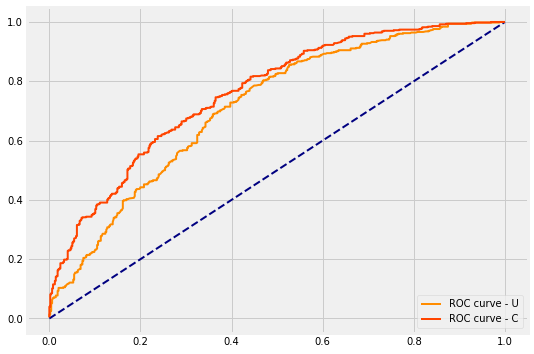

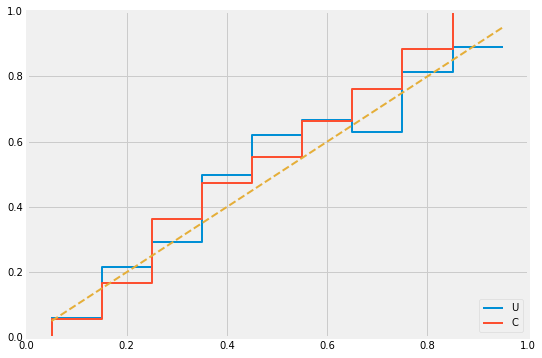

In [15]:
print_validation_results(validation)

In [ ]:
print_validation_results(validation)

In [ ]:
from scipy.stats import beta
print("rand guessing")
rand_guess = beta.rvs(a=10, b=10, size=(validation.shape[0],2))
validation[:,[1,2]] = rand_guess
print_validation_results(validation)

In [ ]:
sample_valid_set.reset_index(drop=True).to_csv('sample_valid_set.csv',index=False)